# Negation signal - with bag of words
## Loading dataset

In [18]:
from datetime import datetime
from negation_signal_common import create_semi_dataset, create_vectorizer, create_columns_names
from negation_signal_common import create_features_list, save_to_csv
from utils import get_datasets


def create_dataset(dataset, sufix):
    ouput_name = '{}.csv'.format(dataset[:-4])
    print('{} START Creating semi dataset {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), dataset))
    X_train, X_test = create_semi_dataset(dataset)
    vect_lemma = create_vectorizer(X_train)
    column_names = create_columns_names(X_train, vect_lemma, add_bow=True)
    print('{} START Creating features list {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), dataset))
    X_train_features_list = create_features_list(X_train, vect_lemma, add_bow=True)
    X_test_features_list = create_features_list(X_test, vect_lemma, add_bow=True)
    print('{} START Save csv {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), dataset))
    save_to_csv(ouput_name + sufix + '-train', column_names, X_train_features_list)
    save_to_csv(ouput_name + sufix + '-test', column_names, X_test_features_list)
    print('{} START Save csv {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), dataset))


for dataset in get_datasets():
    create_dataset(dataset, '-sig-bow')

2017-05-02 13:16:28 START Creating features list dataset/beletria/merged.xml
START Creating semidataset dataset/beletria/merged.xml
END Creating semidataset dataset/beletria/merged.xml
2017-05-02 13:16:28 START Creating features list dataset/beletria/merged.xml


2017-05-02 13:18:22 START Save csv dataset/beletria/merged.xml


2017-05-02 13:19:54 START Save csv dataset/beletria/merged.xml


2017-05-02 13:19:56 START Creating features list dataset/recenzie/merged.xml
START Creating semidataset dataset/recenzie/merged.xml


END Creating semidataset dataset/recenzie/merged.xml
2017-05-02 13:20:00 START Creating features list dataset/recenzie/merged.xml


2017-05-02 13:22:28 START Save csv dataset/recenzie/merged.xml


2017-05-02 13:24:05 START Save csv dataset/recenzie/merged.xml
2017-05-02 13:24:07 START Creating features list dataset/snk/merged.xml
START Creating semidataset dataset/snk/merged.xml
END Creating semidataset dataset/snk/merged.xml
2017-05-02 13:24:07 START Creating features list dataset/snk/merged.xml


2017-05-02 13:24:58 START Save csv dataset/snk/merged.xml


2017-05-02 13:25:38 START Save csv dataset/snk/merged.xml
2017-05-02 13:25:39 START Creating features list dataset/sport/merged.xml
START Creating semidataset dataset/sport/merged.xml


END Creating semidataset dataset/sport/merged.xml
2017-05-02 13:25:39 START Creating features list dataset/sport/merged.xml


2017-05-02 13:29:06 START Save csv dataset/sport/merged.xml


2017-05-02 13:32:58 START Save csv dataset/sport/merged.xml
2017-05-02 13:33:02 START Creating features list dataset/vlastne_mario/merged.xml
START Creating semidataset dataset/vlastne_mario/merged.xml


END Creating semidataset dataset/vlastne_mario/merged.xml
2017-05-02 13:33:03 START Creating features list dataset/vlastne_mario/merged.xml


2017-05-02 13:33:06 START Save csv dataset/vlastne_mario/merged.xml


2017-05-02 13:33:07 START Save csv dataset/vlastne_mario/merged.xml


## Training

In [6]:
%%time
import pandas as pd

# Load dataset
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

CPU times: user 20.2 s, sys: 2.05 s, total: 22.3 s
Wall time: 24.1 s


In [15]:
df2_train = df_train[df_train.columns.difference(['token', 'lemma', 'POS', 'is_negation'])]
df2_test = df_test[df_test.columns.difference(['token', 'lemma', 'POS', 'is_negation'])]

In [30]:
%%time
# Import Library of Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC

model = MultinomialNB()
# model = GaussianNB(priors=[0.8, 0.2])
# model = BernoulliNB()
# model = SVC()

# Train the model using the training sets 
model.fit(df2_train, df_train.is_negation)

CPU times: user 3.33 s, sys: 1.24 s, total: 4.57 s
Wall time: 5.39 s


## Metrics

In [31]:
from sklearn import metrics

y_pred = model.predict(df2_test)
y_true = df_test.is_negation

print('Accuracy: {}'.format(metrics.accuracy_score(y_true, y_pred)))
print('Precision: {}'.format(metrics.precision_score(y_true, y_pred)))
print('Recall: {}'.format(metrics.recall_score(y_true, y_pred)))
print('F1 score: {}'.format(metrics.f1_score(y_true, y_pred)))

print(metrics.classification_report(y_true, y_pred))

Accuracy: 0.9615605278255881
Precision: 0.9090909090909091
Recall: 0.13157894736842105
F1 score: 0.22988505747126434
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      1667
          1       0.91      0.13      0.23        76

avg / total       0.96      0.96      0.95      1743



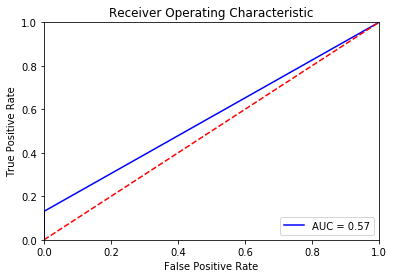

In [32]:
import matplotlib.pyplot as plt

fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
# Grid Search for Algorithm Tuning
import numpy as np
from sklearn.model_selection import GridSearchCV
# prepare a range of alpha values to test
alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0])
# create and fit a ridge regression model, testing each alpha
model = MultinomialNB()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid.fit(df2_train, df_train.is_negation)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

/Users/jozefg/.virtualenvs/neg/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


/Users/jozefg/.virtualenvs/neg/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


/Users/jozefg/.virtualenvs/neg/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e+00,   1.00000e-01,   1.00000e-02,   1.00000e-03,
         1.00000e-04,   0.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)
0.957593123209
1.0
